<a href="https://colab.research.google.com/github/dfsosa785/deploying-machine-learning-models/blob/master/SuperLearnerModel_EMA_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
- In this trial, we define a function augment_data that takes in the original time series forex dataset (original_df) and another dataset with values greater than the 95th percentile (percentile_95_df). The augmentation_factor parameter controls the proportion of augmented samples to generate.

- We start by creating an empty dataframe augmented_df with the same column structure as the original dataset. We then append the original data points from original_df to the augmented_df.

- Next, we compute the number of augmented samples to generate based on the augmentation_factor and the size of the original_df. We iterate over this number and randomly select data points from the percentile_95_df. These randomly selected samples are then appended to the augmented_df.

- We have added a noise_std parameter which controls the standard deviation of the noise that will be added to the augmented samples.

- Inside the for loop, after randomly selecting a data point from the percentile_95_df, we add some Gaussian noise to the augmented sample using np.random.normal(0, noise_std, len(augmented_sample)). The noise is generated from a Gaussian distribution with mean 0 and standard deviation noise_std.

- This noisy augmented sample is then appended to the augmented_df.

You can use this updated augment_data function to generate an augmented dataset that incorporates randomly selected samples from the percentile_95_df along with some added noise. This allows the model to learn from a more diverse set of examples and account for some level of uncertainty in the data.


In [ ]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29413 sha256=56a5a21f37900dce68039eed1df39b1e4f119c7e3058dc1f898b025da606d5ae
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
#from google.colab import data_table
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import PowerTransformer
from scipy import stats
import ta
from scipy.stats import mstats
from sklearn.metrics import make_scorer
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import statsmodels.stats.diagnostic as smd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif, chi2, SelectFromModel, VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, VarianceThreshold
from sklearn.feature_selection import RFE
from sklearn.ensemble import VotingRegressor
from sklearn.feature_selection import SelectKBest, f_regression,SelectPercentile
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.tree import DecisionTreeRegressor
import pickle
from sklearn.feature_selection import RFE

# DataBase

In [ ]:
df_full = pd.read_csv('/content/drive/MyDrive/monobot/DeafReload/Merged_Data.csv',usecols=['datetime','topWick','body','bottomWick','ticks','spread',
                                                                                           'open','high','low','close','Y_5'])

In [ ]:
# prompt: rename datetime column by timestamp_column

df_full.rename(columns={'datetime': 'timestamp_column'}, inplace=True)


In [ ]:
#timestamp-column
df_full['timestamp_column'] = pd.to_datetime(df_full['timestamp_column'])

In [ ]:
df_full.shape

(9811696, 11)

In [ ]:
# prompt: filter in df_full only one month

df_full.loc[(df_full['timestamp_column'] >= "2023-01-03 07:31:10") & (df_full['timestamp_column'] <= "2023-01-30 23:57:22")].shape

(961448, 11)

In [ ]:
df_full = df_full[(df_full['Y_5'] != 0)]
print(f'Data size: {len(df_full)}')

Data size: 9686226


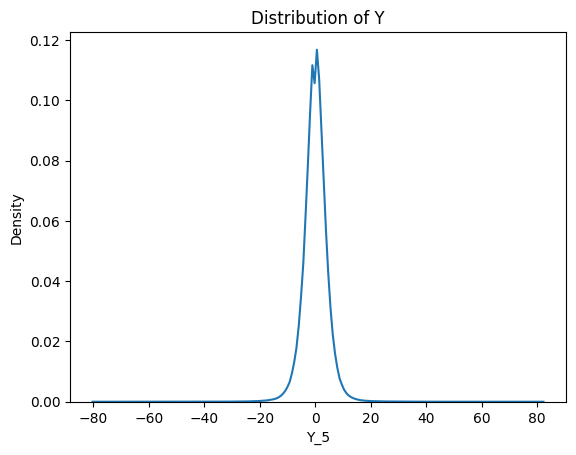

In [ ]:
plt.figure()
sns.kdeplot(df_full['Y_5'])
plt.title(f'Distribution of Y')
plt.show()

# Split

In [ ]:
#Train/Valid/Test
df_train_full = df_full[(df_full["timestamp_column"]>=("2023-01-03 07:31:10")) & (df_full["timestamp_column"]<="2023-10-31 23:57:22")]
#df_valid = df_full[(df_full["datetime"]>("2023-09-29 23:57:22")) & (df_full["datetime"]<="2023-10-31 23:57:50")] # for valid
df_test_full = df_full[(df_full["timestamp_column"]>("2023-10-31 23:57:22")) & (df_full["timestamp_column"]<="2023-12-08 23:29:17")] # yes/not

In [ ]:
print(f'Train size: {len(df_train_full)}')
#print(f'Valid size: {len(df_valid)}')
print(f'Test size: {len(df_test_full)}')

Train size: 8659032
Test size: 1024282


# % of data

In [ ]:
# Calculate the desired sample size as a percentage of the total records
sample_percentage = 8
sample_size = int(len(df_train_full) * (sample_percentage / 100.0))

In [ ]:
# Perform random sampling
sample_df = df_train_full.sample(n=sample_size, random_state=42)
print(f'Sample size: {len(sample_df)}')

Sample size: 692722


In [ ]:
original_df = sample_df.copy()
print(f'Original size: {len(original_df)}')

Original size: 692722


In [ ]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 692722 entries, 5745855 to 6552498
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   timestamp_column  692722 non-null  datetime64[ns]
 1   topWick           692722 non-null  int64         
 2   body              692722 non-null  int64         
 3   bottomWick        692722 non-null  int64         
 4   ticks             692722 non-null  int64         
 5   spread            692722 non-null  int64         
 6   open              692722 non-null  float64       
 7   high              692722 non-null  float64       
 8   low               692722 non-null  float64       
 9   close             692722 non-null  float64       
 10  Y_5               692722 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(5)
memory usage: 63.4 MB


In [ ]:
original_df.describe(percentiles=[0.8,0.90,0.95]).round(2)

,topWick,body,bottomWick,ticks,spread,open,high,low,close,Y_5
count,692722.00,692722.00,692722.00,692722.00,692722.00,692722.00,692722.00,692722.00,692722.00,692722.00
mean,0.08,0.80,0.08,2.40,13.46,1.08,1.08,1.08,1.08,0.01
std,0.40,1.66,0.40,1.53,11.93,0.02,0.02,0.02,0.02,4.45
min,0.00,0.00,0.00,1.00,0.00,1.04,1.04,1.04,1.04,-70.80
50%,0.00,0.00,0.00,2.00,10.00,1.08,1.08,1.08,1.08,0.10
80%,0.00,1.00,0.00,3.00,19.00,1.10,1.10,1.10,1.10,3.10
90%,0.00,2.00,0.00,4.00,26.00,1.10,1.10,1.10,1.10,4.90
95%,1.00,4.00,1.00,5.00,32.00,1.11,1.11,1.11,1.11,6.60
max,31.00,160.00,28.00,19.00,508.00,1.13,1.13,1.13,1.13,65.70


# 95 percentile

In [ ]:
percentile_95_df = original_df[(original_df['body'] >= 4) & (original_df['ticks'] >= 5) & (original_df['spread'] >= 32) & ((original_df['Y_5'] >= 6.6) | (original_df['Y_5'] <= -6.6))]

In [ ]:
percentile_95_df['timestamp_column'] = pd.to_datetime(percentile_95_df['timestamp_column'])

<ipython-input-17-9a302103f8c9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  percentile_95_df['timestamp_column'] = pd.to_datetime(percentile_95_df['timestamp_column'])


In [ ]:
percentile_95_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4068 entries, 874135 to 6202854
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   timestamp_column  4068 non-null   datetime64[ns]
 1   topWick           4068 non-null   int64         
 2   body              4068 non-null   int64         
 3   bottomWick        4068 non-null   int64         
 4   ticks             4068 non-null   int64         
 5   spread            4068 non-null   int64         
 6   open              4068 non-null   float64       
 7   high              4068 non-null   float64       
 8   low               4068 non-null   float64       
 9   close             4068 non-null   float64       
 10  Y_5               4068 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(5)
memory usage: 381.4 KB


In [ ]:
percentile_95_df.describe(percentiles=[0.8,0.90,0.95]).round(2)

,topWick,body,bottomWick,ticks,spread,open,high,low,close,Y_5
count,4068.00,4068.00,4068.00,4068.00,4068.00,4068.00,4068.00,4068.00,4068.00,4068.00
mean,0.53,7.77,0.55,6.72,48.61,1.08,1.08,1.08,1.08,0.31
std,1.39,5.05,1.59,1.78,24.32,0.02,0.02,0.02,0.02,13.35
min,0.00,4.00,0.00,5.00,32.00,1.05,1.05,1.04,1.04,-69.30
50%,0.00,7.00,0.00,6.00,42.00,1.08,1.08,1.08,1.08,6.60
80%,1.00,10.00,1.00,8.00,55.00,1.09,1.09,1.09,1.09,11.10
90%,2.00,14.00,2.00,9.00,67.00,1.10,1.10,1.10,1.10,15.00
95%,4.00,17.00,3.00,10.00,82.00,1.11,1.11,1.11,1.11,20.10
max,22.00,83.00,28.00,19.00,429.00,1.13,1.13,1.13,1.13,65.70


# Data augmentation
- In this function, original_df represents your original time series dataset, and percentile_95_df represents the dataset containing values greater than the 95th percentile.

- You define the parameters augmentation_factor, which determines the proportion of augmented samples to generate, and noise_std, which controls the standard deviation of the added noise.

- Next, you call the augment_data function, passing in original_df, percentile_95_df, augmentation_factor, and noise_std as the function arguments. The function will return the augmented dataset, which you can store in the augmented_df variable.

- After obtaining the augmented dataset, you can use it for further preprocessing, model training, or any other analysis you need to perform.

Remember to adjust the parameters (augmentation_factor and noise_std) based on your specific requirements and dataset characteristics.

In [ ]:
#original_df = original_df.iloc[:,1:]
#print(f'Original size: {len(original_df)}')

In [ ]:
#percentile_95_df = percentile_95_df.iloc[:,1:]
#print(f'95 percentile size: {len(percentile_95_df)}')

In [ ]:
def augment_data(original_df, percentile_95_df, augmentation_factor, noise_std):
    # Excluding the timestamp column
    columns_to_augment = original_df.columns[1:]

    # Add original data points to augmented dataset
    augmented_df = pd.concat([original_df] * (int(augmentation_factor) + 1), ignore_index=True)

    # Compute the number of augmented samples to generate
    num_augmented_samples = int(len(original_df) * augmentation_factor)

    # Randomly select indices from the 95th percentile dataset
    random_indices = np.random.choice(percentile_95_df.index, num_augmented_samples)

    # Repeat the selected samples from the 95th percentile dataset
    augmented_samples = percentile_95_df.loc[random_indices].reset_index(drop=True)

    # Add noise to the selected samples
    for column in columns_to_augment:
        noise = np.random.normal(0, noise_std, size=len(augmented_samples))
        augmented_samples[column] += noise

    # Add the augmented samples to the augmented dataset
    augmented_df = pd.concat([augmented_df, augmented_samples], ignore_index=True)

    return augmented_df

In [ ]:
#def augment_data(original_df, percentile_95_df, augmentation_factor, noise_std):
#    # Excluding the timestamp column
#    columns_to_augment = original_df.columns[1:]
#
#    # Add original data points to augmented dataset
#    augmented_df = pd.concat([original_df] * (int(augmentation_factor) + 1), ignore_index=True)
#
#    # Compute the number of augmented samples to generate
#    num_augmented_samples = int(len(original_df) * augmentation_factor)
#
#    # Randomly select indices from the 95th percentile dataset
#    random_indices = np.random.choice(percentile_95_df.index, num_augmented_samples)
#
#    # Repeat the selected samples from the 95th percentile dataset
#    augmented_samples = percentile_95_df.loc[random_indices].reset_index(drop=True)
#
#    # Add noise to the selected samples
#    augmented_samples[columns_to_augment] += noise_std
#
#    # Add the augmented samples to the augmented dataset
#    augmented_df = pd.concat([augmented_df, augmented_samples], ignore_index=True)
#
#    return augmented_df

## augmentation function explain

*augment_data that takes four parameters: original_df, percentile_95_df, augmentation_factor, and noise_std. It returns an augmented dataset by adding additional samples to the original_df based on the percentile_95_df, with added noise.*
Here is a step-by-step explanation of the code:

1. columns_to_augment = original_df.columns[1:]: This line extracts the columns to be augmented from the original_df dataframe. It assumes that the first column is a timestamp and excludes it from the list of columns to augment.

2. augmented_df = pd.concat([original_df] * (int(augmentation_factor) + 1), ignore_index=True): This line creates a new dataframe called augmented_df which starts by concatenating the original_df dataframe with itself (intensified by augmentation_factor). By setting ignore_index=True, the concatenated dataframe will have a new index.

3. num_augmented_samples = int(len(original_df) * augmentation_factor): This calculates the number of augmented samples to generate based on the length of the original_df and the augmentation_factor.

4. random_indices = np.random.choice(percentile_95_df.index, num_augmented_samples): This line generates random indices by selecting num_augmented_samples random samples from the index of the percentile_95_df dataframe.

5. augmented_samples = percentile_95_df.loc[random_indices].reset_index(drop=True): Here, the random indices obtained in the previous step are used to select corresponding rows from the percentile_95_df dataframe, creating a new dataframe called augmented_samples. The reset_index(drop=True) resets the index of the resulting dataframe.

6. augmented_samples[columns_to_augment] += noise_std: This line adds noise to the selected samples in the columns_to_augment using the noise_std value. It modifies the augmented_samples dataframe in-place.

7. augmented_df = pd.concat([augmented_df, augmented_samples], ignore_index=True): The augmented samples are then concatenated with the augmented_df dataframe created in step 2, resulting in a final augmented dataset.

Finally, the augmented dataframe is returned as the output of the function.

*In summary, the function generates an augmented dataset by repeating the original dataset, selecting random samples from the percentile_95_df, adding noise to those samples, and concatenating them with the original dataset. This technique can be useful for increasing the diversity of the dataset and potentially improving the performance of machine learning models.*

In [ ]:
print(original_df.shape)
print(percentile_95_df.shape)

(692722, 11)
(4068, 11)


In [ ]:
# Define the augmentation factor and noise standard deviation
augmentation_factor = 1.0  # Set the desired augmentation factor
noise_std = 0.3  # Set the desired standard deviation of noise

**augmentation_factor**
- When augmentation_factor = 2.0, it means that the size of the augmented dataset will be twice the size of the original dataset. The value of augmentation_factor determines the proportion of augmented samples to generate relative to the original dataset.

- For example, if your original dataset has 100 samples and you set augmentation_factor = 2.0, the augmented dataset will have an additional 200 samples (twice the size of the original dataset).

- By adjusting the augmentation_factor, you can control the amount of augmentation and the resulting size of the augmented dataset. Higher values of augmentation_factor will generate more augmented samples, increasing the dataset's size, while lower values will generate fewer augmented samples.

**noise_std**
- When noise_std = 0.1, it means that Gaussian noise with a standard deviation of 0.1 will be added to the augmented samples. The value of noise_std controls the magnitude or amplitude of the added noise.

- In the augment_data function, we generate the Gaussian noise using np.random.normal(0, noise_std, len(augmented_sample)). Here, the mean of the Gaussian distribution is 0, and the standard deviation is noise_std.

- By adjusting the value of noise_std, you can control the amount of noise added to the augmented samples. A higher noise_std will result in a larger range of random noise values added to the data, introducing more variability. Conversely, a lower noise_std will result in smaller variations, generating less noisy samples.

- The purpose of adding noise is to simulate and capture the inherent uncertainty or variability present in the data. It can help make the model more robust by exposing it to different patterns and variations within the data.

Remember to choose an appropriate noise_std value depending on the characteristics of your dataset and the desired level of noise addition. Experimentation and fine-tuning may be needed to determine the suitable value for your specific task.

In [ ]:
# Calculate the size of augmented_df
original_rows = original_df.shape[0]
num_augmented_samples = int(original_rows * augmentation_factor)
augmented_rows = original_rows + num_augmented_samples

num_columns = original_df.shape[1]

final_size = (augmented_rows, num_columns)

print("Size of augmented_df: {} rows, {} columns".format(*final_size))

Size of augmented_df: 1385444 rows, 11 columns


In [ ]:
# Call the `augment_data` function with the excluded columns
#augmented_df = augment_data(original_array, percentile_95_array, augmentation_factor, noise_std)
augmented_df = augment_data(original_df, percentile_95_df, augmentation_factor, noise_std)

In [ ]:
augmented_df.describe(percentiles=[0.8,0.90,0.95]).round(2)

,topWick,body,bottomWick,ticks,spread,open,high,low,close,Y_5
count,2078166.00,2078166.00,2078166.00,2078166.00,2078166.00,2078166.00,2078166.00,2078166.00,2078166.00,2078166.00
mean,0.23,3.13,0.24,3.84,25.19,1.08,1.08,1.08,1.08,0.10
std,0.91,4.61,1.02,2.61,23.86,0.17,0.17,0.17,0.17,8.52
min,-1.34,0.00,-1.40,1.00,0.00,-0.31,-0.66,-0.39,-0.46,-70.80
50%,0.00,1.00,0.00,3.00,17.00,1.08,1.08,1.08,1.08,0.10
80%,0.14,5.43,0.14,6.11,40.84,1.10,1.10,1.10,1.10,6.40
90%,0.95,8.51,0.94,7.14,50.74,1.24,1.24,1.24,1.24,9.60
95%,1.33,11.63,1.30,8.09,61.79,1.39,1.39,1.39,1.39,13.13
max,31.00,160.00,28.80,19.90,508.00,2.56,2.50,2.45,2.62,66.60


In [ ]:
augmented_df.shape

(2078166, 11)

In [ ]:
augmented_df.to_csv('/content/drive/MyDrive/monobot/DeafReload/augmented_df_v2.csv', index=False)

# Read augmented data

In [ ]:
augmented_df = pd.read_csv('/content/drive/MyDrive/monobot/DeafReload/augmented_df_Y_5_no_transform.csv')
print(augmented_df.shape)

(4545989, 11)


In [ ]:
#timestamp-column
augmented_df['timestamp_column'] = pd.to_datetime(augmented_df['timestamp_column'])

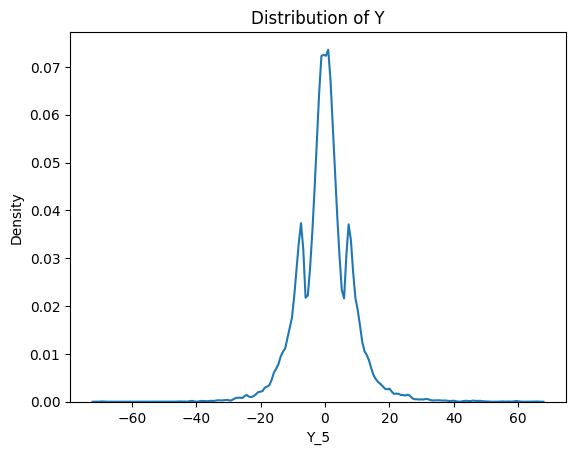

In [ ]:
plt.figure()
sns.kdeplot(augmented_df['Y_5'])
plt.title(f'Distribution of Y')
plt.show()

# Features Engeenireing AD

In [ ]:
# Specify the columns that contain NaN values
columns_to_convert = ['topWick','body',	'bottomWick','ticks','spread','open','high','low','close','Y_5']

In [ ]:
# Convert columns with NaN values to numeric format
for column in columns_to_convert:
    augmented_df[column] = pd.to_numeric(augmented_df[column])

In [ ]:
augmented_df.describe(percentiles=[0.8,0.90,0.95]).round(2)

,topWick,body,bottomWick,ticks,spread,open,high,low,close,Y_5
count,2078166.00,2078166.00,2078166.00,2078166.00,2078166.00,2078166.00,2078166.00,2078166.00,2078166.00,2078166.00
mean,0.23,3.13,0.24,3.84,25.19,1.08,1.08,1.08,1.08,0.10
std,0.91,4.61,1.02,2.61,23.86,0.17,0.17,0.17,0.17,8.52
min,-1.34,0.00,-1.40,1.00,0.00,-0.31,-0.66,-0.39,-0.46,-70.80
50%,0.00,1.00,0.00,3.00,17.00,1.08,1.08,1.08,1.08,0.10
80%,0.14,5.43,0.14,6.11,40.84,1.10,1.10,1.10,1.10,6.40
90%,0.95,8.51,0.94,7.14,50.74,1.24,1.24,1.24,1.24,9.60
95%,1.33,11.63,1.30,8.09,61.79,1.39,1.39,1.39,1.39,13.13
max,31.00,160.00,28.80,19.90,508.00,2.56,2.50,2.45,2.62,66.60


In [ ]:
#drop nan if is any
augmented_df_nn = augmented_df.dropna()

In [ ]:
#create variable of data name to only chance one time
data_variable = augmented_df_nn.copy()

# Target Transformation

In [ ]:
# 'Y_5' is the original variable - Apply the signed square root transformation
data_variable['Y_5_signed_sqrt'] = np.sqrt(np.abs(data_variable['Y_5'])) * np.sign(data_variable['Y_5'])

In [ ]:
data_variable.describe(percentiles=[0.8,0.90,0.95]).round(2)

,topWick,body,bottomWick,ticks,spread,open,high,low,close,Y_5,Y_5_signed_sqrt
count,2078166.00,2078166.00,2078166.00,2078166.00,2078166.00,2078166.00,2078166.00,2078166.00,2078166.00,2078166.00,2078166.00
mean,0.23,3.13,0.24,3.84,25.19,1.08,1.08,1.08,1.08,0.10,0.02
std,0.91,4.61,1.02,2.61,23.86,0.17,0.17,0.17,0.17,8.52,2.46
min,-1.34,0.00,-1.40,1.00,0.00,-0.31,-0.66,-0.39,-0.46,-70.80,-8.41
50%,0.00,1.00,0.00,3.00,17.00,1.08,1.08,1.08,1.08,0.10,0.32
80%,0.14,5.43,0.14,6.11,40.84,1.10,1.10,1.10,1.10,6.40,2.53
90%,0.95,8.51,0.94,7.14,50.74,1.24,1.24,1.24,1.24,9.60,3.10
95%,1.33,11.63,1.30,8.09,61.79,1.39,1.39,1.39,1.39,13.13,3.62
max,31.00,160.00,28.80,19.90,508.00,2.56,2.50,2.45,2.62,66.60,8.16


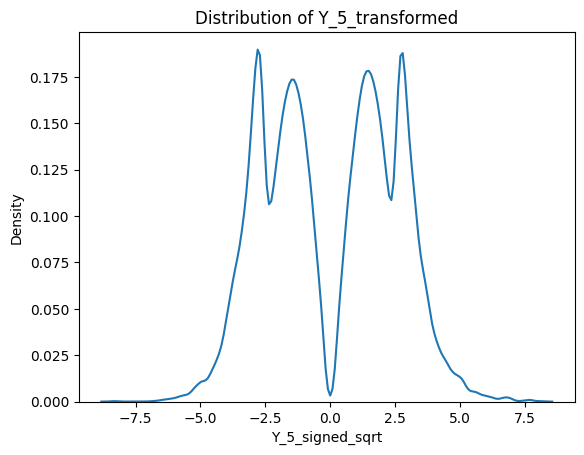

In [ ]:
#plt.figure()
sns.kdeplot(data_variable['Y_5_signed_sqrt'])
##sns.kdeplot(data_variable['Y_5'])
plt.title(f'Distribution of Y_5_transformed')
plt.show()

# Random Noises

In [ ]:
# 2 new noise variables from normal and uniform distribution
data_variable['noise_normal'] = np.random.normal(0, 1, size=data_variable.shape[0])
data_variable['noise_uniform'] = np.random.uniform(0, 1, size=data_variable.shape[0])

# Datetime features

In [ ]:
# prompt: create new featires from datetime variable
data_variable['hour'] = data_variable['timestamp_column'].apply(lambda x: x.hour)
data_variable['day'] = data_variable['timestamp_column'].apply(lambda x: x.day)
data_variable['month'] = data_variable['timestamp_column'].apply(lambda x: x.month)
#data['year'] = data['datetime'].apply(lambda x: x.year)

# Lags

In [ ]:
one_min = 60
two_min = 120
three_min = 180
four_min = 240
five_min = 300
ten_min = 600
fifteen_min =900
twenty_min = 1200
twentyfive_min = 1500
thirty_min = 1800
fourty_min = 2400
sixty_min = 3600

## body lags

In [ ]:
# prompt: create lags from body, ticks and spead features
data_variable['body_1'] = data_variable['body'].shift(one_min)
data_variable['body_2'] = data_variable['body'].shift(two_min)
data_variable['body_3'] = data_variable['body'].shift(three_min)
data_variable['body_4'] = data_variable['body'].shift(four_min)
data_variable['body_5'] = data_variable['body'].shift(five_min)
data_variable['body_10'] = data_variable['body'].shift(ten_min)
data_variable['body_15'] = data_variable['body'].shift(fifteen_min)
data_variable['body_20'] = data_variable['body'].shift(twenty_min)
data_variable['body_25'] = data_variable['body'].shift(twentyfive_min)
data_variable['body_30'] = data_variable['body'].shift(thirty_min)
data_variable['body_40'] = data_variable['body'].shift(fourty_min)
data_variable['body_60'] = data_variable['body'].shift(sixty_min)

## ticks lags

In [ ]:
#for ticks
data_variable['ticks_1'] = data_variable['ticks'].shift(one_min)
data_variable['ticks_2'] = data_variable['ticks'].shift(two_min)
data_variable['ticks_3'] = data_variable['ticks'].shift(three_min)
data_variable['ticks_4'] = data_variable['ticks'].shift(four_min)
data_variable['ticks_5'] = data_variable['ticks'].shift(five_min)
data_variable['ticks_10'] = data_variable['ticks'].shift(ten_min)
data_variable['ticks_15'] = data_variable['ticks'].shift(fifteen_min)
data_variable['ticks_20'] = data_variable['ticks'].shift(twenty_min)
data_variable['ticks_25'] = data_variable['ticks'].shift(twentyfive_min)
data_variable['ticks_30'] = data_variable['ticks'].shift(thirty_min)
data_variable['ticks_40'] = data_variable['ticks'].shift(fourty_min)
data_variable['ticks_60'] = data_variable['ticks'].shift(sixty_min)

## spread lags

In [ ]:
#for spread
data_variable['spread_1'] = data_variable['spread'].shift(one_min)
data_variable['spread_2'] = data_variable['spread'].shift(two_min)
data_variable['spread_3'] = data_variable['spread'].shift(three_min)
data_variable['spread_4'] = data_variable['spread'].shift(four_min)
data_variable['spread_5'] = data_variable['spread'].shift(five_min)
data_variable['spread_10'] = data_variable['spread'].shift(ten_min)
data_variable['spread_15'] = data_variable['spread'].shift(fifteen_min)
data_variable['spread_20'] = data_variable['spread'].shift(twenty_min)
data_variable['spread_25'] = data_variable['spread'].shift(twentyfive_min)
data_variable['spread_30'] = data_variable['spread'].shift(thirty_min)
data_variable['spread_40'] = data_variable['spread'].shift(fourty_min)
data_variable['spread_60'] = data_variable['spread'].shift(sixty_min)

## Original target

In [ ]:
#for Y
#data_variable['Y_5_1'] = data_variable['Y_5'].shift(one_min)
#data_variable['Y_5_2'] = data_variable['Y_5'].shift(two_min)
#data_variable['Y_5_3'] = data_variable['Y_5'].shift(three_min)
#data_variable['Y_5_4'] = data_variable['Y_5'].shift(four_min)
#data_variable['Y_5_5'] = data_variable['Y_5'].shift(five_min)
#data_variable['Y_5_10'] = data_variable['Y_5'].shift(ten_min)
#data_variable['Y_5_15'] = data_variable['Y_5'].shift(fifteen_min)
#data_variable['Y_5_20'] = data_variable['Y_5'].shift(twenty_min)
#data_variable['Y_5_25'] = data_variable['Y_5'].shift(twentyfive_min)
#data_variable['Y_5_30'] = data_variable['Y_5'].shift(thirty_min)
#data_variable['Y_5_40'] = data_variable['Y_5'].shift(fourty_min)
#data_variable['Y_5_60'] = data_variable['Y_5'].shift(sixty_min)

## Transformed target

In [ ]:
#for Y transformed
data_variable['Y_5_1_sign'] = data_variable['Y_5_signed_sqrt'].shift(one_min)
data_variable['Y_5_2_sign'] = data_variable['Y_5_signed_sqrt'].shift(two_min)
data_variable['Y_5_3_sign'] = data_variable['Y_5_signed_sqrt'].shift(three_min)
data_variable['Y_5_4_sign'] = data_variable['Y_5_signed_sqrt'].shift(four_min)
data_variable['Y_5_5_sign'] = data_variable['Y_5_signed_sqrt'].shift(five_min)
data_variable['Y_5_10_sign'] = data_variable['Y_5_signed_sqrt'].shift(ten_min)
data_variable['Y_5_15_sign'] = data_variable['Y_5_signed_sqrt'].shift(fifteen_min)
data_variable['Y_5_20_sign'] = data_variable['Y_5_signed_sqrt'].shift(twenty_min)
data_variable['Y_5_25_sign'] = data_variable['Y_5_signed_sqrt'].shift(twentyfive_min)
data_variable['Y_5_30_sign'] = data_variable['Y_5_signed_sqrt'].shift(thirty_min)
data_variable['Y_5_40_sign'] = data_variable['Y_5_signed_sqrt'].shift(fourty_min)
data_variable['Y_5_60_sign'] = data_variable['Y_5_signed_sqrt'].shift(sixty_min)

In [ ]:
# prompt: statistics transformation for spread,body and ticks features
data_variable['spread_log'] = np.log(data_variable['spread']+1)
data_variable['body_log'] = np.log(data_variable['body']+1)
data_variable['ticks_log'] = np.log(data_variable['ticks']+1)

In [ ]:
# prompt: Square Root Transformation for spread,body and ticks
data_variable['spread_sqrt'] = np.sqrt(data_variable['spread'])
data_variable['body_sqrt'] = np.sqrt(data_variable['body'])
data_variable['ticks_sqrt'] = np.sqrt(data_variable['ticks'])

In [ ]:
# Adding a constant to avoid zero and negative values
constant = 1

In [ ]:
# prompt: Power Transformation
data_variable['spread_transformed'] = data_variable['spread'] + constant
data_variable['body_transformed'] = data_variable['body'] + constant
data_variable['ticks_transformed'] = data_variable['ticks'] + constant

In [ ]:
# Applying the Box-Cox transformation
data_variable['spread_boxcox'], lam = stats.boxcox(data_variable['spread_transformed'])
data_variable['body_boxcox'], lam = stats.boxcox(data_variable['body_transformed'])
data_variable['ticks_boxcox'], lam = stats.boxcox(data_variable['ticks_transformed'])

In [ ]:
# Printing the lambda value which indicates the power transformation
print("Lambda:", lam)

Lambda: -0.048366170415252104


In [ ]:
# prompt: Interaction Terms
data_variable['spread_x_body'] = data_variable['spread'] * data_variable['body']
data_variable['spread_x_ticks'] = data_variable['spread'] * data_variable['ticks']
data_variable['body_x_ticks'] = data_variable['body'] * data_variable['ticks']

# EMA
- It is a type of moving average that gives more weight to recent data points and assigns lesser weight to older data points. This is achieved by applying a smoothing factor to the calculation.

- The formula for calculating the EMA is:

> *EMA = (Current Close - Previous EMA) * Smoothing Factor + Previous EMA*

- The Smoothing Factor determines the weight assigned to the current close price and is usually a value between 0 and 1. A higher smoothing factor gives more weight to recent data points, making the EMA more responsive to recent price changes.

EMA is commonly used in technical analysis to identify trends and generate trading signals. Traders often compare the EMA with a simple moving average (SMA) to get a sense of the current market sentiment.

In [ ]:
# Calculate the 8-period EMA using the 'close' column
data_variable['ema_8_cl'] = ta.trend.ema_indicator(data_variable['close'], window=8)

# Calculate the 21-period EMA using the 'close' column
data_variable['ema_21_cl'] = ta.trend.ema_indicator(data_variable['close'], window=21)

# Calculate the 34-period EMA using the 'close' column
data_variable['ema_34_cl'] = ta.trend.ema_indicator(data_variable['close'], window=34)

# Calculate the 55-period EMA using the 'close' column
data_variable['ema_55_cl'] = ta.trend.ema_indicator(data_variable['close'], window=55)

In [ ]:
# Calculate the 8-period EMA using the 'open' column
data_variable['ema_8_op'] = ta.trend.ema_indicator(data_variable['open'], window=8)

# Calculate the 21-period EMA using the 'open' column
data_variable['ema_21_op'] = ta.trend.ema_indicator(data_variable['open'], window=21)

# Calculate the 34-period EMA using the 'open' column
data_variable['ema_34_op'] = ta.trend.ema_indicator(data_variable['open'], window=34)

# Calculate the 55-period EMA using the 'open' column
data_variable['ema_55_op'] = ta.trend.ema_indicator(data_variable['open'], window=55)

In [ ]:
# Calculate the 8-period EMA using the 'high' column
data_variable['ema_8_hi'] = ta.trend.ema_indicator(data_variable['high'], window=8)

# Calculate the 21-period EMA using the 'high' column
data_variable['ema_21_hi'] = ta.trend.ema_indicator(data_variable['high'], window=21)

# Calculate the 34-period EMA using the 'high' column
data_variable['ema_34_hi'] = ta.trend.ema_indicator(data_variable['high'], window=34)

# Calculate the 55-period EMA using the 'high' column
data_variable['ema_55_hi'] = ta.trend.ema_indicator(data_variable['high'], window=55)

In [ ]:
# Calculate the 8-period EMA using the 'low' column
data_variable['ema_8_lo'] = ta.trend.ema_indicator(data_variable['low'], window=8)

# Calculate the 21-period EMA using the 'low' column
data_variable['ema_21_lo'] = ta.trend.ema_indicator(data_variable['low'], window=21)

# Calculate the 34-period EMA using the 'low' column
data_variable['ema_34_lo'] = ta.trend.ema_indicator(data_variable['low'], window=34)

# Calculate the 55-period EMA using the 'low' column
data_variable['ema_55_lo'] = ta.trend.ema_indicator(data_variable['low'], window=55)

## MACD
Moving Average Convergence Divergence (MACD)

In [ ]:
# Calculate the MACD
macd_cl = ta.trend.MACD(data_variable['close'])
data_variable['macd_line_cl'] = macd_cl.macd()
#data_variable['macd_signal_line_cl'] = macd_cl_signal()
data_variable['macd_histogram_cl'] = macd_cl.macd_diff()

In [ ]:
# Calculate the MACD
macd_op = ta.trend.MACD(data_variable['open'])
data_variable['macd_line_op'] = macd_op.macd()
data_variable['macd_signal_line_op'] = macd_op.macd_signal()
data_variable['macd_histogram_op'] = macd_op.macd_diff()

In [ ]:
# Calculate the MACD
macd_hi = ta.trend.MACD(data_variable['high'])
data_variable['macd_line_hi'] = macd_hi.macd()
data_variable['macd_signal_line_hi'] = macd_hi.macd_signal()
data_variable['macd_histogram_hi'] = macd_hi.macd_diff()

In [ ]:
# Calculate the MACD
macd_l = ta.trend.MACD(data_variable['low'])
data_variable['macd_line_l'] = macd_l.macd()
data_variable['macd_signal_line_l'] = macd_l.macd_signal()
data_variable['macd_histogram_l'] = macd_l.macd_diff()

# Base for Model

# Voting Method 2 (PICK)

In [ ]:
print(data_variable.shape)

(2078166, 107)


In [ ]:
data_variable.columns.tolist()

['timestamp_column',
 'topWick',
 'body',
 'bottomWick',
 'ticks',
 'spread',
 'open',
 'high',
 'low',
 'close',
 'Y_5',
 'Y_5_signed_sqrt',
 'noise_normal',
 'noise_uniform',
 'hour',
 'day',
 'month',
 'body_1',
 'body_2',
 'body_3',
 'body_4',
 'body_5',
 'body_10',
 'body_15',
 'body_20',
 'body_25',
 'body_30',
 'body_40',
 'body_60',
 'ticks_1',
 'ticks_2',
 'ticks_3',
 'ticks_4',
 'ticks_5',
 'ticks_10',
 'ticks_15',
 'ticks_20',
 'ticks_25',
 'ticks_30',
 'ticks_40',
 'ticks_60',
 'spread_1',
 'spread_2',
 'spread_3',
 'spread_4',
 'spread_5',
 'spread_10',
 'spread_15',
 'spread_20',
 'spread_25',
 'spread_30',
 'spread_40',
 'spread_60',
 'Y_5_1_sign',
 'Y_5_2_sign',
 'Y_5_3_sign',
 'Y_5_4_sign',
 'Y_5_5_sign',
 'Y_5_10_sign',
 'Y_5_15_sign',
 'Y_5_20_sign',
 'Y_5_25_sign',
 'Y_5_30_sign',
 'Y_5_40_sign',
 'Y_5_60_sign',
 'spread_log',
 'body_log',
 'ticks_log',
 'spread_sqrt',
 'body_sqrt',
 'ticks_sqrt',
 'spread_transformed',
 'body_transformed',
 'ticks_transformed',
 's

In [ ]:
df_sample = data_variable.dropna()

In [ ]:
# prompt: pick the last row in df_sample

last_row = df_sample.tail(1)


In [ ]:
last_row

,timestamp_column,topWick,body,bottomWick,ticks,spread,open,high,low,close,...,macd_histogram_cl,macd_line_op,macd_signal_line_op,macd_histogram_op,macd_line_hi,macd_signal_line_hi,macd_histogram_hi,macd_line_l,macd_signal_line_l,macd_histogram_l
2078165,2023-04-26 15:30:28,0.480327,3.446166,0.040394,6.522971,31.932735,1.96526,1.192953,1.098954,0.992717,...,-0.026608,0.105022,0.032724,0.072298,0.021133,0.000766,0.020367,-0.020115,-0.049969,0.029854


In [ ]:
df_sample.isnull().sum()

timestamp_column       0
topWick                0
body                   0
bottomWick             0
ticks                  0
                      ..
macd_signal_line_hi    0
macd_histogram_hi      0
macd_line_l            0
macd_signal_line_l     0
macd_histogram_l       0
Length: 107, dtype: int64

In [ ]:
X = df_sample.drop(['timestamp_column', 'Y_5','Y_5_signed_sqrt','open', 'high', 'low', 'close','spread_transformed','body_transformed','ticks_transformed'], axis=1)
y = df_sample['Y_5_signed_sqrt']

In [ ]:
# Standardize the input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Create the feature selection method
#feature_selector = VarianceThreshold(threshold=0.01)
feature_selector = SelectPercentile(score_func=f_regression, percentile=30)

In [ ]:
# Create the individual regressor models
linear_model = LinearRegression()
ridge_model = Ridge(alpha=1.0)
decision_tree = DecisionTreeRegressor()

In [ ]:
# Create the voting regressor with different models
voting_regressor = VotingRegressor([('linear', linear_model), ('ridge', ridge_model), ('tree', decision_tree)])

In [ ]:
# Fit the feature selector on the standardized input data
X_selected = feature_selector.fit_transform(X_scaled, y)

In [ ]:
# Fit the voting regressor on the selected features
voting_regressor.fit(X_selected, y)

VotingRegressor(estimators=[('linear', LinearRegression()), ('ridge', Ridge()),
                            ('tree', DecisionTreeRegressor())])

In [ ]:
# Get the indices of the selected features
feature_indices = feature_selector.get_support(indices=True)

In [ ]:
# Get the selected feature names
selected_feature_names = X.columns[feature_indices]

In [ ]:
# Get the voting values of the selected features
voting_values = voting_regressor.predict(X_selected)

In [ ]:
# Determine the minimum length among the arrays
min_length = min(len(selected_feature_names), len(voting_values))

In [ ]:
# Create a new DataFrame with the selected feature names and voting values
results_df = pd.DataFrame({'Feature': selected_feature_names[:min_length], 'VotingValue': voting_values[:min_length]})

In [ ]:
# prompt: sort values
results_df.sort_values('VotingValue', ascending=False)

,Feature,VotingValue
26,body_x_ticks,0.977040
3,spread,0.781978
9,ticks_15,0.752890
6,month,0.624229
4,hour,0.597770
22,body_boxcox,0.484968
18,ticks_log,0.457269
25,spread_x_ticks,0.355616
0,topWick,0.330706
10,ticks_25,0.271864


<Axes: ylabel='Feature'>

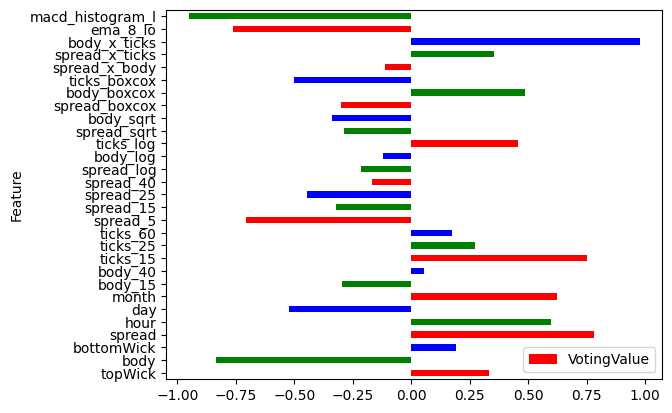

In [ ]:
results_df.plot.barh(x='Feature', y='VotingValue', color=['red', 'green', 'blue'])

# Models

#### **Model Methodology Explained:**

1. Outer Cross-Validation (TimeSeriesSplit): The dataset (X_train_cv_final and Y_train_cv) is split into training and validation sets using TimeSeriesSplit. In each iteration of the outer cross-validation loop, a different split of the data is used. The loop iterates 10 times (n_splits=10), meaning there will be 10 different training and validation sets.

2. Inner Cross-Validation (TimeSeriesSplit) and Hyperparameter Tuning: Inside the outer cross-validation loop, another TimeSeriesSplit is created to perform inner cross-validation for hyperparameter tuning. This inner cross-validation is done using a fixed train-validation split within each outer fold. In this case, n_splits=3 is used for the inner cross-validation, meaning three different splits of the training set are used.

3. LightGBM Regression Model: A LightGBM regressor (lgb.LGBMRegressor) is initialized as the base model for hyperparameter tuning.

3. RandomizedSearchCV: RandomizedSearchCV is used to perform hyperparameter tuning. It takes the initialized LightGBM regressor, a parameter grid (param_grid), and the inner cross-validation (inner_cv) as inputs. It performs random search over the parameter grid and evaluates the models using mean absolute percentage error ("neg_mean_absolute_percentage_error") as the scoring metric. Only one iteration (n_iter=1) is used in this example for the sake of brevity. The job is run in parallel using multiple cores (n_jobs=-1) and the verbosity level is set to 2 (verbose=2) for printing progress updates.

4. Best Model Selection: After the hyperparameter tuning is complete, the best model found during RandomizedSearchCV is extracted using lgb_random.best_estimator_.

5. Training Time: At the end of each iteration of the outer cross-validation loop, the training time of the current iteration is calculated and printed.

**Summary:**
*Nested cross-validation is performed to evaluate the performance of a LightGBM regression model with hyperparameter tuning. The outer loop splits the dataset into multiple training and validation sets and loops through them. In each outer loop iteration, an inner cross-validation loop is performed to tune the hyperparameters of the model using RandomizedSearchCV. The best model from hyperparameter tuning is selected and training time is tracked and printed. This process allows for a comprehensive evaluation of the model's performance and helps to select the best hyperparameters.*



In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, max_error, explained_variance_score, mean_absolute_percentage_error
from google.colab import data_table
from sklearn.metrics import r2_score
from sklearn.metrics import median_absolute_error
import time
import joblib
data_table.enable_dataframe_formatter()

In [ ]:
df = data_variable.copy()
df.shape

(2078166, 107)

In [ ]:
selected_feature_names

Index(['topWick', 'body', 'bottomWick', 'spread', 'hour', 'day', 'month',
       'body_15', 'body_40', 'ticks_15', 'ticks_25', 'ticks_60', 'spread_5',
       'spread_15', 'spread_25', 'spread_40', 'spread_log', 'body_log',
       'ticks_log', 'spread_sqrt', 'body_sqrt', 'spread_boxcox', 'body_boxcox',
       'ticks_boxcox', 'spread_x_body', 'spread_x_ticks', 'body_x_ticks',
       'ema_8_lo', 'macd_histogram_l'],
      dtype='object')

In [ ]:
#drop nan
df = df.dropna()

In [ ]:
#check NaN values
df.isna().sum()

timestamp_column       0
topWick                0
body                   0
bottomWick             0
ticks                  0
                      ..
macd_signal_line_hi    0
macd_histogram_hi      0
macd_line_l            0
macd_signal_line_l     0
macd_histogram_l       0
Length: 107, dtype: int64

# Split data

In [ ]:
df_to_model = df[[
    'timestamp_column','topWick', 'body', 'bottomWick', 'spread', 'hour', 'day', 'month',
       'body_15', 'body_40', 'ticks_15', 'ticks_25', 'ticks_60', 'spread_5',
       'spread_15', 'spread_25', 'spread_40', 'spread_log', 'body_log',
       'ticks_log', 'spread_sqrt', 'body_sqrt', 'spread_x_body', 'spread_x_ticks', 'body_x_ticks',
        'Y_5','Y_5_signed_sqrt']]

In [ ]:
df_to_model.shape

(2074566, 27)

In [ ]:
#Train/Valid/Test
df_train = df_to_model[(df_to_model["timestamp_column"]>=("2023-01-03 07:31:10")) & (df_to_model["timestamp_column"]<="2023-06-30 23:57:22")]
df_valid = df_to_model[(df_to_model["timestamp_column"]>("2023-06-30 23:57:22")) & (df_to_model["timestamp_column"]<="2023-08-31 23:57:50")]
df_test = df_to_model[(df_to_model["timestamp_column"]>("2023-08-31 23:57:50"))]

In [ ]:
#shape
print(df_to_model.shape,"original data size")
print(df_train.shape,"train data size")
print(df_valid.shape,"valid data size")
print(df_test.shape, "test data size")

(2074566, 27) original data size
(1312737, 27) train data size
(383345, 27) valid data size
(378484, 27) test data size


# Train-Validation-Y

In [ ]:
##Model configuration
Y_train_cv, X_train_cv = df_train.Y_5_signed_sqrt, df_train
Y_validation, X_validation = df_valid.Y_5_signed_sqrt, df_valid

In [ ]:
Xs = X_train_cv.columns.to_list()

In [ ]:
Xs

['timestamp_column',
 'topWick',
 'body',
 'bottomWick',
 'spread',
 'hour',
 'day',
 'month',
 'body_15',
 'body_40',
 'ticks_15',
 'ticks_25',
 'ticks_60',
 'spread_5',
 'spread_15',
 'spread_25',
 'spread_40',
 'spread_log',
 'body_log',
 'ticks_log',
 'spread_sqrt',
 'body_sqrt',
 'spread_x_body',
 'spread_x_ticks',
 'body_x_ticks',
 'Y_5',
 'Y_5_signed_sqrt']

In [ ]:
X_train_cv_final = df_train[Xs]
#inner_cv_groups = X_train_cv_final["date_time_1"]
X_train_cv_final.drop(["timestamp_column",'Y_5','Y_5_signed_sqrt'], axis=1, inplace=True)

In [ ]:
X_validation_final = X_validation[Xs]
#outer_cv_groups = X_validation_final["datetime"]
X_validation_final.drop(["timestamp_column",'Y_5','Y_5_signed_sqrt'], axis=1, inplace=True)

In [ ]:
print(X_train_cv_final.shape)
print(Y_train_cv.shape)

(1312737, 24)
(1312737,)


# 1. Random Forest Regressor

## Param Grid

In [ ]:
# Hyperparameter grid for Random Forest Regressor
#param_grid = {
#    'n_estimators': [120],  # number of decision trees in the forest
#    'max_depth': [5],  # maximum depth of the decision trees
#    'min_samples_split': [15],  # minimum number of samples to split a node
#    'min_samples_leaf': [15],  # minimum number of samples required to be at each leaf node
#    'bootstrap': [True]  # method for sampling data points
#}

In [ ]:
# Hyperparameter grid for Random Forest Regressor
param_grid = {
    'n_estimators': [80],  # number of decision trees in the forest
    'max_depth': [16],  # maximum depth of the decision trees
    'min_samples_split': [100],  # minimum number of samples to split a node
    'min_samples_leaf': [5],  # minimum number of samples required to be at each leaf node
    'bootstrap': [True]  # method for sampling data points
}

## Train RF

In [ ]:
# Define the number of splits for rolling window cross-validation
n_splits = 3

# Initialize rolling window time series split
rolling_cv = TimeSeriesSplit(n_splits=n_splits)

def mean_directional_accuracy(y_true, y_pred):
    y_true_sign = np.sign(y_true)
    y_pred_sign = np.sign(y_pred)
    directional_accuracy = np.mean(y_true_sign == y_pred_sign)
    return directional_accuracy

# Create a scoring function for Mean Directional Accuracy
scorer_mda = make_scorer(mean_directional_accuracy)

# Define the scoring metrics to be used
scoring_metrics = {
    "Neg Mean Absolute Error": "neg_mean_absolute_error",
    "Neg Mean Squared Error": "neg_mean_squared_error",
    "Explained Variance Score": "explained_variance",
    "Mean Directional Accuracy": scorer_mda
}

# Outer cross-validation with rolling window
for train_index, test_index in rolling_cv.split(X_train_cv_final):
    X_train, X_test = X_train_cv_final.iloc[train_index], X_train_cv_final.iloc[test_index]
    y_train, y_test = Y_train_cv.iloc[train_index], Y_train_cv.iloc[test_index]

    # Track training time
    start_time = time.time()

    # Inner cross-validation with TimeSeriesSplit
    inner_cv = TimeSeriesSplit(n_splits=2)

    # Create RandomForestRegressor
    rf_model = RandomForestRegressor()

    # Perform RandomizedSearchCV with inner CV
    rf_random = RandomizedSearchCV(
        estimator=rf_model,
        param_distributions=param_grid,
        cv=inner_cv,
        n_iter=1,
        scoring=scoring_metrics,
        refit="Neg Mean Absolute Error",
        n_jobs=-1,
        verbose=2
    )
    rf_random.fit(X_train, y_train)

    # Best model from hyperparameter tuning
    best_rf = rf_random.best_estimator_

    # Calculate and print training time
    end_time = time.time()
    training_time = end_time - start_time
    print("Training time:", training_time)

    # Evaluate on the validation set using different scoring metrics
    y_pred = best_rf.predict(X_test)

    # Calculate scoring metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    evs = explained_variance_score(y_test, y_pred)
    mda = mean_directional_accuracy(y_test, y_pred)

    print("Validation Set Evaluation:")
    print("Neg Mean Absolute Error:", -mae)
    print("Neg Mean Squared Error:", -mse)
    print("Explained Variance Score:", evs)
    print("Mean Directional Accuracy:", mda)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
Training time: 367.5836808681488
Validation Set Evaluation:
Neg Mean Absolute Error: -1.552227220646
Neg Mean Squared Error: -3.0041872276896977
Explained Variance Score: 0.07165184027905536
Mean Directional Accuracy: 0.6085823806157521
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Training time: 855.611251115799
Validation Set Evaluation:
Neg Mean Absolute Error: -2.146279733178766
Neg Mean Squared Error: -5.842222171446844
Explained Variance Score: 0.11389629795939582
Mean Directional Accuracy: 0.6332392804036759
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Training time: 1859.329686164856
Validation Set Evaluation:
Neg Mean Absolute Error: -2.501198912710621
Neg Mean Squared Error: -7.644839403403704
Explained Variance Score: 0.37572444428361773
Mean Directional Accuracy: 0.802622918850401


In [ ]:
best_rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 24,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 200,
 'min_samples_split': 150,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 120,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

## Validation Set

In [ ]:
#validation
y_valid_pred = best_rf.predict(X_validation_final)

In [ ]:
result_valid=X_validation_final.copy()
result_valid["timestamp_column"]=X_validation.timestamp_column
result_valid["Y_5"]= Y_validation
result_valid["set_type"]='valid'

In [ ]:
result_valid["pred_valid"]=y_valid_pred

In [ ]:
print(mean_squared_error(Y_validation, y_valid_pred))
print(r2_score(Y_validation, y_valid_pred))
print(median_absolute_error(Y_validation, y_valid_pred))
print(max_error(Y_validation, y_valid_pred),"esta metrica debe ser baja")

5.809770709648059
-0.07304368440647702
1.7869400920951466
7.947905524200044 esta metrica debe ser baja


<Axes: title={'center': 'predicho vs real'}>

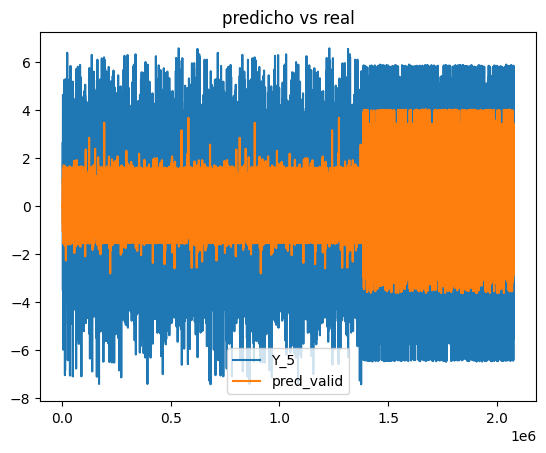

In [ ]:
result_valid[['Y_5','pred_valid']].plot(title="predicho vs real")

In [ ]:
def mean_absolute_percentage_error(actual, predicted):
    actual, predicted = np.array(actual), np.array(predicted)
    return np.mean(np.abs((actual - predicted) / actual)) * 100

In [ ]:
def mean_absolute_percentage_error(actual, predicted):
    mask = actual != 0  # create a mask to handle the cases where actual is zero
    actual = actual[mask]
    predicted = predicted[mask]
    return np.mean(np.abs((actual - predicted) / actual)) * 100

In [ ]:
mean_absolute_percentage_error(result_valid['Y_5'], result_valid['pred_valid'])

100.07920444637395

## Test Set

In [ ]:
#test
y_test_pred_rf = best_rf.predict(df_test[X_train_cv_final.columns])

In [ ]:
result_test_rf = df_test[X_train_cv_final.columns]
result_test_rf["timestamp_column"]=df_test.timestamp_column
result_test_rf["set_type"]='test'
result_test_rf['Y_5'] = df_test.Y_5

<ipython-input-124-89d0ebf5f456>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_test_rf["timestamp_column"]=df_test.timestamp_column
<ipython-input-124-89d0ebf5f456>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_test_rf["set_type"]='test'
<ipython-input-124-89d0ebf5f456>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

In [ ]:
result_test_rf["pred_test_rf"]=y_test_pred_rf

In [ ]:
print(mean_squared_error(df_test.Y_5, y_test_pred_rf))
print(r2_score(df_test.Y_5, y_test_pred_rf))
print(median_absolute_error(df_test.Y_5, y_test_pred_rf))
print(max_error(df_test.Y_5, y_test_pred_rf),"esta metrica debe ser baja")

59.92253173884558
-0.015509212688896712
4.7052335475249984
53.83736119595511 esta metrica debe ser baja


In [ ]:
mape_test = mean_absolute_percentage_error(result_test_rf['Y_5'], result_test_rf['pred_test_rf'])
print('MAPE: ', mape_test)

MAPE:  104.34455094401618


<Axes: title={'center': 'R2: 0.0'}>

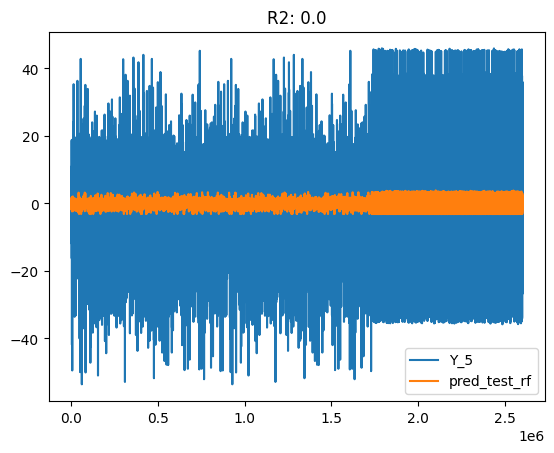

In [ ]:
result_test_rf[['Y_5','pred_test_rf']].plot(title="R2: "+str(round(r2_score(result_test_rf['Y_5'], result_test_rf['pred_test_rf']),2)))

<Axes: ylabel='Density'>

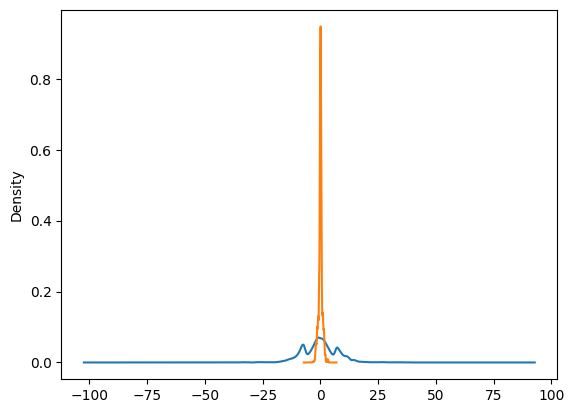

In [ ]:
result_test_rf["Y_5"].plot.kde()
result_test_rf["pred_test_rf"].plot.kde()

In [ ]:
result_test_rf.head(5)

,topWick,body,bottomWick,spread,hour,day,month,body_15,body_40,ticks_15,...,ticks_boxcox,spread_x_body,spread_x_ticks,body_x_ticks,ema_8_lo,macd_histogram_l,timestamp_column,set_type,Y_5,pred_test_rf
3601,1.0,0.0,0.0,20.0,18,28,9,0.0,0.0,2.0,...,1.548222,0.0,80.0,0.0,1.080123,-0.000153,2023-09-28 18:54:58,test,-4.9,0.133243
3602,0.0,0.0,1.0,37.0,19,18,10,1.0,0.0,2.0,...,1.978013,0.0,259.0,0.0,1.074000,-0.001873,2023-10-18 19:14:09,test,0.4,-0.186457
3608,0.0,1.0,0.0,11.0,21,29,9,0.0,0.0,1.0,...,1.069855,11.0,22.0,2.0,1.075821,-0.001064,2023-09-29 21:06:28,test,0.1,-0.077145
3612,0.0,0.0,0.0,6.0,22,31,10,0.0,0.0,1.0,...,0.681625,0.0,6.0,0.0,1.078369,-0.000285,2023-10-31 22:23:58,test,-4.0,0.314430
3619,0.0,0.0,0.0,5.0,1,19,10,0.0,1.0,1.0,...,0.681625,0.0,5.0,0.0,1.071397,-0.001673,2023-10-19 01:30:33,test,-0.3,0.146931


# Save RF

In [ ]:
filename = 'rf_model_lags_v2.sav'
pickle.dump(best_rf, open(filename, 'wb'))

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
loaded_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 12,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 15,
 'min_samples_split': 50,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 120,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
# Save the best model after nested CV
#joblib.dump(best_rf, "best_rf_model.pkl")  # Save as .pkl

['best_rf_model.pkl']

# 2. LIghtgbm

## Param Grid lg

In [ ]:
# Hyperparameter grid for LightGBM
param_grid = {
    'learning_rate': [1.9],   # step size for each iteration in boosting
    'n_estimators': [1000],  # number of trees or boosting rounds
    'num_leaves': [500],  # maximum number of leaves in full trees
    'max_depth': [48],  # maximum tree depth for base learners
    'min_child_samples': [1],  # minimum number of data needed in a child (leaf), equivalent to min_data_in_leaf from your previous grid
    'max_bin': [200],  # max number of bins that feature values will be bucketed in
    'subsample': [1],  # fraction of samples to be used for fitting the individual base learners, corresponds to bagging_fraction
    'colsample_bytree': [1],  # fraction of columns to be randomly sampled for each tree
    'reg_alpha': [0],  # L1 regularization term on weights
    'reg_lambda': [0.1]  # L2 regularization term on weights
}

## Train lg

**If preserving the sign of the predicted values is important for your final prediction**, you can consider using a metric that is specifically designed to evaluate the direction or sign of the predictions. One such metric is the Mean Directional Accuracy (MDA) or Directional Accuracy (DA).

- Mean Directional Accuracy (MDA) or Directional Accuracy (DA):

- The MDA or DA measures the proportion of predictions that correctly capture the direction (sign) of the true values.
- It calculates the percentage of predictions that have the same sign (up or down) as the true values.
- MDA ranges from 0 to 1, with higher values indicating better performance in capturing the sign direction.

In [ ]:
# Define the number of splits for rolling window cross-validation
n_splits = 3

# Initialize rolling window time series split
rolling_cv = TimeSeriesSplit(n_splits=n_splits)

def mean_directional_accuracy(y_true, y_pred):
    y_true_sign = np.sign(y_true)
    y_pred_sign = np.sign(y_pred)
    directional_accuracy = np.mean(y_true_sign == y_pred_sign)
    return directional_accuracy

# Create a scoring function for Mean Directional Accuracy
scorer_mda = make_scorer(mean_directional_accuracy)

# Define the scoring metrics to be used
scoring_metrics = {
    "Neg Mean Absolute Error": "neg_mean_absolute_error",
    "Neg Mean Squared Error": "neg_mean_squared_error",
    "Explained Variance Score": "explained_variance",
    "Mean Directional Accuracy": scorer_mda
}

# Define the scoring metrics to be used
#scoring_metrics = {
#    "Neg Mean Absolute Error": "neg_mean_absolute_error",
#    "Neg Mean Squared Error": "neg_mean_squared_error",
#    "Explained Variance Score": "explained_variance",
#    "Mean Directional Accuracy": make_scorer(mean_directional_accuracy)
#}

# Outer cross-validation with rolling window
for train_index, test_index in rolling_cv.split(X_train_cv_final):
    X_train, X_test = X_train_cv_final.iloc[train_index], X_train_cv_final.iloc[test_index]
    y_train, y_test = Y_train_cv.iloc[train_index], Y_train_cv.iloc[test_index]

    # Track training time
    start_time = time.time()

    # Inner cross-validation with TimeSeriesSplit
    inner_cv = TimeSeriesSplit(n_splits=2)

    # Create LightGBM regressor
    lgb_model = LGBMRegressor(force_row_wise=True)

    # Perform RandomizedSearchCV with inner CV
    lgb_random = RandomizedSearchCV(
        estimator=lgb_model,
        param_distributions=param_grid,
        cv=inner_cv,
        n_iter=1,
        scoring=scoring_metrics,
        refit="Neg Mean Absolute Error",
        n_jobs=-1,
        verbose=2
    )
    lgb_random.fit(X_train, y_train)

    # Best model from hyperparameter tuning
    best_lgb = lgb_random.best_estimator_

    # Calculate and print training time
    end_time = time.time()
    training_time = end_time - start_time
    print("Training time:", training_time)

    # Evaluate on the validation set using different scoring metrics
    y_pred = best_lgb.predict(X_test)

    # Calculate scoring metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    evs = explained_variance_score(y_test, y_pred)
    mda = mean_directional_accuracy(y_test, y_pred)

    print("Validation Set Evaluation:")
    print("Neg Mean Absolute Error:", -mae)
    print("Neg Mean Squared Error:", -mse)
    print("Explained Variance Score:", evs)
    print("Mean Directional Accuracy:", mda)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[LightGBM] [Info] Total Bins 2454
[LightGBM] [Info] Number of data points in the train set: 328185, number of used features: 27
[LightGBM] [Info] Start training from score 0.024762
Training time: 96.54118919372559
Validation Set Evaluation:
Neg Mean Absolute Error: -1.7678107295404741
Neg Mean Squared Error: -12.025462453677024
Explained Variance Score: -2.716069252681948
Mean Directional Accuracy: 0.8243576774004826
Fitting 2 folds for each of 1 candidates, totalling 2 fits
[LightGBM] [Info] Total Bins 2435
[LightGBM] [Info] Number of data points in the train set: 656369, number of used features: 27
[LightGBM] [Info] Start training from score 0.025421
Training time: 145.65342378616333
Validation Set Evaluation:
Neg Mean Absolute Error: -7.183369348791437
Neg Mean Squared Error: -196.05483071500547
Explained Variance Score: -28.716644504139392
Mean Directional Accuracy: 0.769546961460644
Fitting 2 folds for each of 1 candidates

In [ ]:
best_lgb.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1,
 'importance_type': 'split',
 'learning_rate': 1.9,
 'max_depth': 48,
 'min_child_samples': 1,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 1000,
 'n_jobs': None,
 'num_leaves': 500,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0,
 'reg_lambda': 0.1,
 'subsample': 1,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'force_row_wise': True,
 'max_bin': 200}

## Validation Set lgm

In [ ]:
#validation
y_valid_pred = best_lgb.predict(X_validation_final)

In [ ]:
result_valid=X_validation_final.copy()

In [ ]:
# Apply the inverse of the signed square root transformation
result_valid['Y_5_inverse'] = (Y_validation ** 2) * np.sign(Y_validation)

In [ ]:
result_valid["timestamp_column"]=X_validation.timestamp_column
#result_valid["Y_5"]= Y_validation
result_valid["set_type"]='valid'

In [ ]:
result_valid["pred_valid"]=y_valid_pred

In [ ]:
# Calculate mean absolute error
mae = mean_absolute_error(result_valid.Y_5_inverse, y_valid_pred)

# Calculate mean squared error
mse = mean_squared_error(result_valid.Y_5_inverse, y_valid_pred)

# Calculate explained variance score
evs = explained_variance_score(result_valid.Y_5_inverse, y_valid_pred)

# Calculate mean directional accuracy
mda = np.mean(np.sign(result_valid.Y_5_inverse) == np.sign(y_valid_pred))

# Print the metrics
print("Neg Mean Absolute Error:", -mae)
print("Neg Mean Squared Error:", -mse)
print("Explained Variance Score:", evs)
print("Mean Directional Accuracy:", mda)

Neg Mean Absolute Error: -8.215646112942203
Neg Mean Squared Error: -134.4871082876519
Explained Variance Score: -1.281588488113429
Mean Directional Accuracy: 0.49334672423013215


In [ ]:
#def mean_absolute_percentage_error(actual, predicted):
#    mask = actual != 0  # create a mask to handle the cases where actual is zero
#    actual = actual[mask]
#    predicted = predicted[mask]
#    return np.mean(np.abs((actual - predicted) / actual)) * 100

In [ ]:
mean_absolute_percentage_error(result_valid['Y_5_inverse'], result_valid['pred_valid'])

144.2002402636603

<Axes: title={'center': 'predicho vs real'}>

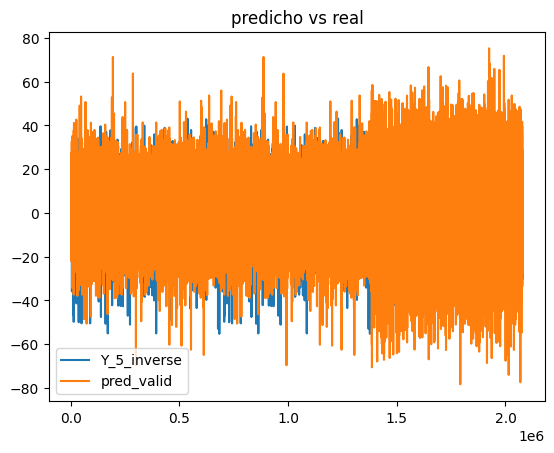

In [ ]:
result_valid[['Y_5_inverse','pred_valid']].plot(title="predicho vs real")

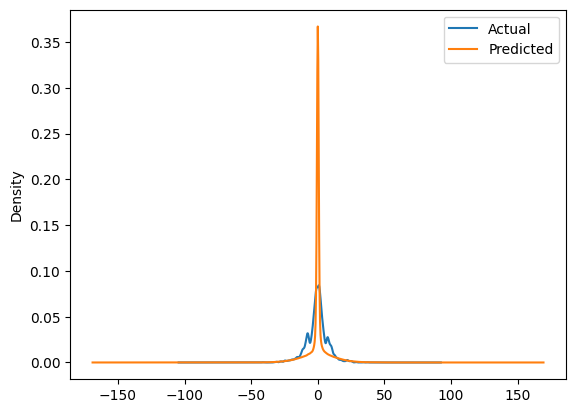

In [ ]:
# prompt: result_valid["Y_5_inverse"].plot.kde() with label

result_valid["Y_5_inverse"].plot.kde(label="Actual")
result_valid["pred_valid"].plot.kde(label="Predicted")
plt.legend()


## Test Set lgm

In [ ]:
y_test_pred_lg = best_lgb.predict(df_test[X_train_cv_final.columns])

In [ ]:
df_test['inverse_signed_sqrt_Y_5'] = np.sign(df_test['Y_5_signed_sqrt']) * (df_test['Y_5_signed_sqrt'] ** 2)

<ipython-input-108-f6b0683e6709>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['inverse_signed_sqrt_Y_5'] = np.sign(df_test['Y_5_signed_sqrt']) * (df_test['Y_5_signed_sqrt'] ** 2)


In [ ]:
result_test_lg=df_test.inverse_signed_sqrt_Y_5.to_frame().copy()
result_test_lg=df_test.copy()
result_test_lg["timestamp_column"]=df_test.timestamp_column
result_test_lg["set_type"]='test'

In [ ]:
result_test_lg["pred_test_lg"]=y_test_pred_lg

In [ ]:
# Calculate mean absolute error
mae = mean_absolute_error(df_test.inverse_signed_sqrt_Y_5, y_test_pred_lg)

# Calculate mean squared error
mse = mean_squared_error(df_test.inverse_signed_sqrt_Y_5, y_test_pred_lg)

# Calculate explained variance score
evs = explained_variance_score(df_test.inverse_signed_sqrt_Y_5, y_test_pred_lg)

# Calculate mean directional accuracy
mda = np.mean(np.sign(df_test.inverse_signed_sqrt_Y_5) == np.sign(y_test_pred_lg))

# Print the metrics
print("Neg Mean Absolute Error:", -mae)
print("Neg Mean Squared Error:", -mse)
print("Explained Variance Score:", evs)
print("Mean Directional Accuracy:", mda)

Neg Mean Absolute Error: -9.729118417206912
Neg Mean Squared Error: -186.74060466392584
Explained Variance Score: -2.1691934530693855
Mean Directional Accuracy: 0.4994028809672271


In [ ]:
#print(mean_squared_error(df_test.inverse_signed_sqrt_Y_5, y_test_pred_lg))
#print(r2_score(df_test.inverse_signed_sqrt_Y_5, y_test_pred_lg))
#print(median_absolute_error(df_test.inverse_signed_sqrt_Y_5, y_test_pred_lg))
#print(max_error(df_test.inverse_signed_sqrt_Y_5, y_test_pred_lg),"esta metrica debe ser baja")

239.9305329926992
-3.020165632507134
4.319335184821369
118.83273040846744 esta metrica debe ser baja


In [ ]:
#def mean_absolute_percentage_error(actual, predicted):
#    mask = actual != 0  # create a mask to handle the cases where actual is zero
#    actual = actual[mask]
#    predicted = predicted[mask]
#    return np.mean(np.abs((actual - predicted) / actual)) * 100

In [ ]:
mean_absolute_percentage_error(result_test_lg['inverse_signed_sqrt_Y_5'], result_test_lg['pred_test_lg'])

193.2533565109828

<Axes: title={'center': 'predicho vs real'}>

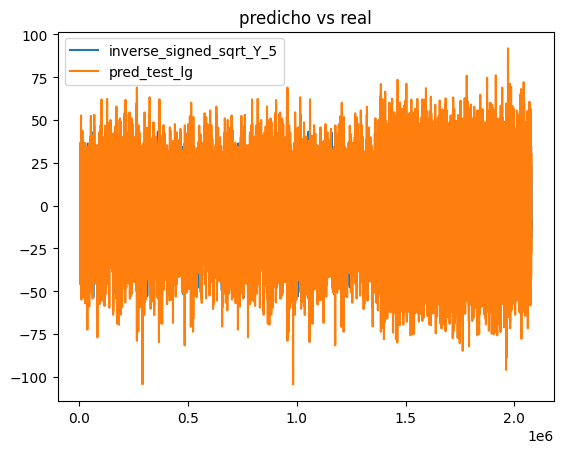

In [ ]:
result_test_lg[['inverse_signed_sqrt_Y_5','pred_test_lg']].plot(title="predicho vs real")

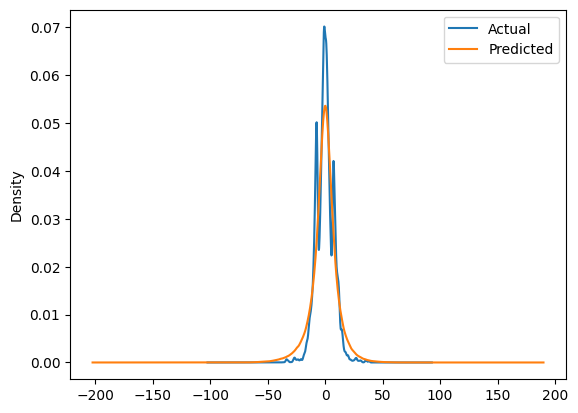

In [ ]:
# prompt: result_test_lg["inverse_signed_sqrt_Y_5"].plot.kde() with label

result_test_lg["inverse_signed_sqrt_Y_5"].plot.kde(label="Actual")
result_test_lg["pred_test_lg"].plot.kde(label="Predicted")
plt.legend()


In [ ]:
result_test_lg.head(20)

,timestamp_column,topWick,body,bottomWick,spread,hour,day,month,body_15,body_40,...,spread_x_body,spread_x_ticks,body_x_ticks,ema_8_lo,macd_histogram_l,Y_5,Y_5_signed_sqrt,inverse_signed_sqrt_Y_5,set_type,pred_test_lg
3601,2023-09-28 18:54:58,1.0,0.0,0.0,20.0,18,28,9,0.0,0.0,...,0.0,80.0,0.0,1.080123,-0.000153,-4.9,-2.213594,-4.9,test,5.900372
3602,2023-10-18 19:14:09,0.0,0.0,1.0,37.0,19,18,10,1.0,0.0,...,0.0,259.0,0.0,1.074000,-0.001873,0.4,0.632456,0.4,test,8.358484
3608,2023-09-29 21:06:28,0.0,1.0,0.0,11.0,21,29,9,0.0,0.0,...,11.0,22.0,2.0,1.075821,-0.001064,0.1,0.316228,0.1,test,-1.056410
3612,2023-10-31 22:23:58,0.0,0.0,0.0,6.0,22,31,10,0.0,0.0,...,0.0,6.0,0.0,1.078369,-0.000285,-4.0,-2.000000,-4.0,test,3.418999
3619,2023-10-19 01:30:33,0.0,0.0,0.0,5.0,1,19,10,0.0,1.0,...,0.0,5.0,0.0,1.071397,-0.001673,-0.3,-0.547723,-0.3,test,1.539394
3623,2023-09-11 10:21:14,0.0,4.0,0.0,55.0,10,11,9,1.0,1.0,...,220.0,550.0,40.0,1.078974,0.000960,-2.3,-1.516575,-2.3,test,8.237704
3624,2023-10-25 17:41:47,0.0,6.0,0.0,56.0,17,25,10,0.0,2.0,...,336.0,616.0,66.0,1.074511,-0.000468,-0.1,-0.316228,-0.1,test,-12.015006
3626,2023-09-08 17:02:20,0.0,0.0,1.0,19.0,17,8,9,1.0,0.0,...,0.0,76.0,0.0,1.074623,-0.000220,10.0,3.162278,10.0,test,-7.659712
3627,2023-10-10 10:12:56,0.0,1.0,0.0,10.0,10,10,10,0.0,0.0,...,10.0,20.0,2.0,1.070527,-0.001304,-4.6,-2.144761,-4.6,test,7.959558
3638,2023-10-20 20:33:38,0.0,1.0,0.0,10.0,20,20,10,0.0,1.0,...,10.0,20.0,2.0,1.082489,-0.000722,5.3,2.302173,5.3,test,2.722661


# Save lg

In [ ]:
filename = 'lg_model_lags_v2.sav'
pickle.dump(best_lgb, open(filename, 'wb'))

In [ ]:
# Save the best model after nested CV
#joblib.dump(best_lgb, "best_lg_model.pkl")  # Save as .pkl

['best_lg_model.pkl']

# HistGradientBoosting

## Param Grid hist

In [ ]:
from sklearn.experimental import enable_hist_gradient_boosting  # Required for HistGradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

In [ ]:
param_grid = {
    "learning_rate": [2.0],  # Rate at which trees learn
    "max_iter": [900],  # Maximum number of iterations (trees)
    "max_depth": [48],  # Maximum depth of each tree
    'max_leaf_nodes': [800],  # Higher maximum leaf nodes increase model complexity
    "min_samples_leaf": [1],  # Minimum samples required to be at a leaf node
    "max_bins": [200],  # Maximum number of bins for histogram construction
    "l2_regularization": [1.2],  # L2 regularization strength
    "early_stopping": [True],  # Stop training if validation score doesn't improve for several iterations
    "random_state": [42]  # Set random seed for reproducibility
}

## Train hist

In [ ]:
# Define the number of splits for rolling window cross-validation
n_splits = 3

# Initialize rolling window time series split
rolling_cv = TimeSeriesSplit(n_splits=n_splits)

def mean_directional_accuracy(y_true, y_pred):
    y_true_sign = np.sign(y_true)
    y_pred_sign = np.sign(y_pred)
    directional_accuracy = np.mean(y_true_sign == y_pred_sign)
    return directional_accuracy

# Create a scoring function for Mean Directional Accuracy
scorer_mda = make_scorer(mean_directional_accuracy)

# Define the scoring metrics to be used
scoring_metrics = {
    "Neg Mean Absolute Error": "neg_mean_absolute_error",
    "Neg Mean Squared Error": "neg_mean_squared_error",
    "Explained Variance Score": "explained_variance",
    "Mean Directional Accuracy": scorer_mda
}

# Outer cross-validation with rolling window
for train_index, test_index in rolling_cv.split(X_train_cv_final):
    X_train, X_test = X_train_cv_final.iloc[train_index], X_train_cv_final.iloc[test_index]
    y_train, y_test = Y_train_cv.iloc[train_index], Y_train_cv.iloc[test_index]

    # Track training time
    start_time = time.time()

    # Inner cross-validation with TimeSeriesSplit
    inner_cv = TimeSeriesSplit(n_splits=2)

    # Create HistGradientBoostingRegressor
    hist_gradient_model = HistGradientBoostingRegressor()

    # Perform RandomizedSearchCV with inner CV
    hist_gradient_random = RandomizedSearchCV(
        estimator=hist_gradient_model,
        param_distributions=param_grid,
        cv=inner_cv,
        n_iter=1,
        scoring=scoring_metrics,
        refit="Neg Mean Absolute Error",
        n_jobs=-1,
        verbose=2
    )
    hist_gradient_random.fit(X_train, y_train)

    # Best model from hyperparameter tuning
    best_hist_gradient = hist_gradient_random.best_estimator_

    # Calculate and print training time
    end_time = time.time()
    training_time = end_time - start_time
    print("Training time:", training_time)

    # Evaluate on the validation set using different scoring metrics
    y_pred = best_hist_gradient.predict(X_test)

    # Calculate scoring metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    evs = explained_variance_score(y_test, y_pred)
    mda = mean_directional_accuracy(y_test, y_pred)

    print("Validation Set Evaluation:")
    print("Neg Mean Absolute Error:", -mae)
    print("Neg Mean Squared Error:", -mse)
    print("Explained Variance Score:", evs)
    print("Mean Directional Accuracy:", mda)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
Training time: 12.474186182022095
Validation Set Evaluation:
Neg Mean Absolute Error: -1.5259961449516726
Neg Mean Squared Error: -3.443392894664194
Explained Variance Score: -0.06406981301509407
Mean Directional Accuracy: 0.5970278867952125
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Training time: 17.57433319091797
Validation Set Evaluation:
Neg Mean Absolute Error: -2.384333382935429
Neg Mean Squared Error: -11.492062138654445
Explained Variance Score: -0.7418343755310357
Mean Directional Accuracy: 0.6051452843526802
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Training time: 16.615253686904907
Validation Set Evaluation:
Neg Mean Absolute Error: -2.368136326516838
Neg Mean Squared Error: -10.098185588430757
Explained Variance Score: 0.17747609939769549
Mean Directional Accuracy: 0.8595483021719523


In [ ]:
best_hist_gradient.get_params()

{'categorical_features': None,
 'early_stopping': True,
 'interaction_cst': None,
 'l2_regularization': 1.2,
 'learning_rate': 2.0,
 'loss': 'squared_error',
 'max_bins': 200,
 'max_depth': 48,
 'max_iter': 900,
 'max_leaf_nodes': 800,
 'min_samples_leaf': 1,
 'monotonic_cst': None,
 'n_iter_no_change': 10,
 'quantile': None,
 'random_state': 42,
 'scoring': 'loss',
 'tol': 1e-07,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

## Validation Set hist

In [ ]:
#validation
y_valid_pred = best_hist_gradient.predict(X_validation_final)

In [ ]:
result_valid=X_validation_final.copy()

In [ ]:
result_valid['inverse_signed_sqrt_Y_5'] = np.sign(Y_validation) * (Y_validation ** 2)

In [ ]:
result_valid["timestamp_column"]=X_validation.timestamp_column
#result_valid["Y_5"]= Y_validation
result_valid["set_type"]='valid'

In [ ]:
result_valid["pred_valid"]=y_valid_pred

In [ ]:
# Calculate mean absolute error
mae = mean_absolute_error(result_valid.inverse_signed_sqrt_Y_5, y_valid_pred)

# Calculate mean squared error
mse = mean_squared_error(result_valid.inverse_signed_sqrt_Y_5, y_valid_pred)

# Calculate explained variance score
evs = explained_variance_score(result_valid.inverse_signed_sqrt_Y_5, y_valid_pred)

# Calculate mean directional accuracy
mda = np.mean(np.sign(result_valid.inverse_signed_sqrt_Y_5) == np.sign(y_valid_pred))

# Print the metrics
print("Neg Mean Absolute Error:", -mae)
print("Neg Mean Squared Error:", -mse)
print("Explained Variance Score:", evs)
print("Mean Directional Accuracy:", mda)

Neg Mean Absolute Error: -5.727355593300058
Neg Mean Squared Error: -77.24143829142147
Explained Variance Score: -0.31342182720148903
Mean Directional Accuracy: 0.4993230640806584


In [ ]:
#print(mean_squared_error(Y_validation, y_valid_pred))
#print(r2_score(Y_validation, y_valid_pred))
#print(median_absolute_error(Y_validation, y_valid_pred))
#print(max_error(Y_validation, y_valid_pred),"esta metrica debe ser baja")

In [ ]:
#def mean_absolute_percentage_error(actual, predicted):
#    mask = actual != 0  # create a mask to handle the cases where actual is zero
#    actual = actual[mask]
#    predicted = predicted[mask]
#    return np.mean(np.abs((actual - predicted) / actual)) * 100

In [ ]:
mean_absolute_percentage_error(result_valid['inverse_signed_sqrt_Y_5'], result_valid['pred_valid'])

141.19430422978246

<Axes: title={'center': 'predicho vs real'}>

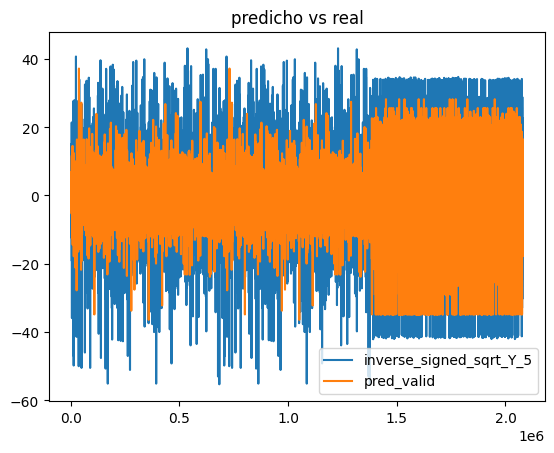

In [ ]:
result_valid[['inverse_signed_sqrt_Y_5','pred_valid']].plot(title="predicho vs real")

## Test Set hist

In [ ]:
y_test_pred_hist = best_hist_gradient.predict(df_test[X_train_cv_final.columns])

In [ ]:
df_test['inverse_signed_sqrt_Y_5'] = np.sign(df_test['Y_5_signed_sqrt']) * (df_test['Y_5_signed_sqrt'] ** 2)

<ipython-input-214-f6b0683e6709>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['inverse_signed_sqrt_Y_5'] = np.sign(df_test['Y_5_signed_sqrt']) * (df_test['Y_5_signed_sqrt'] ** 2)


In [ ]:
result_test_hist=df_test.inverse_signed_sqrt_Y_5.to_frame().copy()
result_test_hist=df_test.copy()
result_test_hist["timestamp_column"]=df_test.timestamp_column
result_test_hist["set_type"]='test'

In [ ]:
result_test_hist["pred_test_hist"] = y_test_pred_hist

In [ ]:
# Calculate mean absolute error
mae = mean_absolute_error(df_test.inverse_signed_sqrt_Y_5, y_test_pred_hist)

# Calculate mean squared error
mse = mean_squared_error(df_test.inverse_signed_sqrt_Y_5, y_test_pred_hist)

# Calculate explained variance score
evs = explained_variance_score(df_test.inverse_signed_sqrt_Y_5, y_test_pred_hist)

# Calculate mean directional accuracy
mda = np.mean(np.sign(df_test.inverse_signed_sqrt_Y_5) == np.sign(y_test_pred_hist))

# Print the metrics
print("Neg Mean Absolute Error:", -mae)
print("Neg Mean Squared Error:", -mse)
print("Explained Variance Score:", evs)
print("Mean Directional Accuracy:", mda)

Neg Mean Absolute Error: -6.474626581329539
Neg Mean Squared Error: -90.3455933800991
Explained Variance Score: -0.5338005062519859
Mean Directional Accuracy: 0.49091639276693333


In [ ]:
#print(mean_squared_error(df_test.inverse_signed_sqrt_Y_5, y_test_pred_hist))
#print(r2_score(df_test.inverse_signed_sqrt_Y_5, y_test_pred_hist))
#print(median_absolute_error(df_test.inverse_signed_sqrt_Y_5, y_test_pred_hist))
#print(max_error(df_test.inverse_signed_sqrt_Y_5, y_test_pred_hist),"esta metrica debe ser baja")

In [ ]:
#mean_absolute_percentage_error(result_test_hist['inverse_signed_sqrt_Y_5'], result_test_hist['pred_test_hist'])

133.2913489013354

<Axes: title={'center': 'predicho vs real'}>

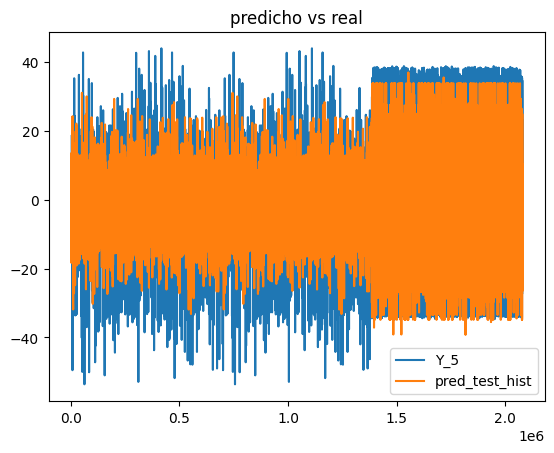

In [ ]:
result_test_hist[['Y_5','pred_test_hist']].plot(title="predicho vs real")

<Axes: ylabel='Density'>

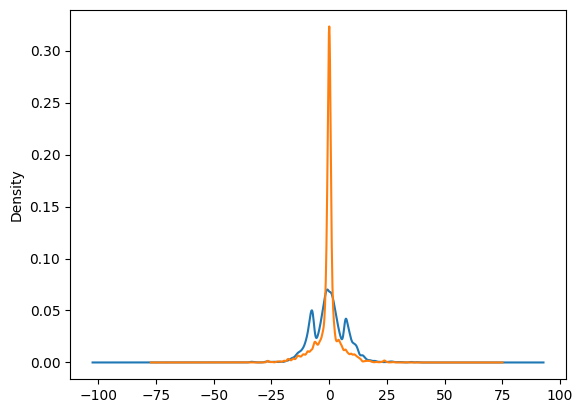

In [ ]:
result_test_hist["inverse_signed_sqrt_Y_5"].plot.kde()
result_test_hist["pred_test_hist"].plot.kde()

In [ ]:
result_test_hist.head(15)

,timestamp_column,topWick,body,bottomWick,spread,hour,day,month,body_15,body_40,...,spread_sqrt,body_sqrt,spread_x_body,spread_x_ticks,body_x_ticks,Y_5,Y_5_signed_sqrt,inverse_signed_sqrt_Y_5,set_type,pred_test_hist
3601,2023-09-28 18:54:58,1.0,0.0,0.0,20.0,18,28,9,0.0,0.0,...,4.472136,0.00000,0.0,80.0,0.0,-4.9,-2.213594,-4.9,test,0.106573
3602,2023-10-18 19:14:09,0.0,0.0,1.0,37.0,19,18,10,1.0,0.0,...,6.082763,0.00000,0.0,259.0,0.0,0.4,0.632456,0.4,test,2.898490
3608,2023-09-29 21:06:28,0.0,1.0,0.0,11.0,21,29,9,0.0,0.0,...,3.316625,1.00000,11.0,22.0,2.0,0.1,0.316228,0.1,test,0.089314
3612,2023-10-31 22:23:58,0.0,0.0,0.0,6.0,22,31,10,0.0,0.0,...,2.449490,0.00000,0.0,6.0,0.0,-4.0,-2.000000,-4.0,test,-1.228988
3619,2023-10-19 01:30:33,0.0,0.0,0.0,5.0,1,19,10,0.0,1.0,...,2.236068,0.00000,0.0,5.0,0.0,-0.3,-0.547723,-0.3,test,0.042291
3623,2023-09-11 10:21:14,0.0,4.0,0.0,55.0,10,11,9,1.0,1.0,...,7.416198,2.00000,220.0,550.0,40.0,-2.3,-1.516575,-2.3,test,-4.877941
3624,2023-10-25 17:41:47,0.0,6.0,0.0,56.0,17,25,10,0.0,2.0,...,7.483315,2.44949,336.0,616.0,66.0,-0.1,-0.316228,-0.1,test,-18.320189
3626,2023-09-08 17:02:20,0.0,0.0,1.0,19.0,17,8,9,1.0,0.0,...,4.358899,0.00000,0.0,76.0,0.0,10.0,3.162278,10.0,test,0.036229
3627,2023-10-10 10:12:56,0.0,1.0,0.0,10.0,10,10,10,0.0,0.0,...,3.162278,1.00000,10.0,20.0,2.0,-4.6,-2.144761,-4.6,test,-0.141251
3638,2023-10-20 20:33:38,0.0,1.0,0.0,10.0,20,20,10,0.0,1.0,...,3.162278,1.00000,10.0,20.0,2.0,5.3,2.302173,5.3,test,0.455162


# Save hist

In [ ]:
filename = 'hist_model_lags_v2.sav'
pickle.dump(best_hist_gradient, open(filename, 'wb'))

In [ ]:
# Save the best model after nested CV
#joblib.dump(best_hist, "best_hist_model.pkl")  # Save as .pkl

['best_hist_model.pkl']

# Super Learner

In [ ]:
from sklearn.model_selection import KFold
from sklearn.base import clone
from sklearn.datasets import make_regression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

In [ ]:
selected_feature_names = ['topWick', 'body', 'bottomWick', 'spread', 'hour', 'day', 'month',
       'body_15', 'body_40', 'ticks_15', 'ticks_25', 'ticks_60', 'spread_5',
       'spread_15', 'spread_25', 'spread_40', 'spread_log', 'body_log',
       'ticks_log', 'spread_sqrt', 'body_sqrt', 'spread_boxcox', 'body_boxcox',
       'ticks_boxcox', 'spread_x_body', 'spread_x_ticks', 'body_x_ticks']

## Define X,y

In [ ]:
#Train/Valid/Test
X_train = df_to_model[(df_to_model["timestamp_column"]>=("2023-01-03 07:31:10")) & (df_to_model["timestamp_column"]<="2023-08-31 23:57:50")]
#df_test = df_to_model[(df_to_model["datetime"]>("2023-10-31 23:57:50")) & (df_to_model["datetime"]<="2023-12-08 23:29:17")]

In [ ]:
print(X_train.shape)
print(df_test.shape)

(1696082, 30)
(378484, 31)


In [ ]:
X_train_ = X_train.dropna()
holdout = df_test.dropna()

In [ ]:
X_train_.columns

Index(['timestamp_column', 'topWick', 'body', 'bottomWick', 'spread', 'hour',
       'day', 'month', 'body_15', 'body_40', 'ticks_15', 'ticks_25',
       'ticks_60', 'spread_5', 'spread_15', 'spread_25', 'spread_40',
       'spread_log', 'body_log', 'ticks_log', 'spread_sqrt', 'body_sqrt',
       'spread_boxcox', 'body_boxcox', 'ticks_boxcox', 'spread_x_body',
       'spread_x_ticks', 'body_x_ticks', 'Y_5', 'Y_5_signed_sqrt'],
      dtype='object')

In [ ]:
X = X_train_[selected_feature_names].values
print(X.shape)
y = X_train_['Y_5'].values
print(y.shape)

(1696082, 27)
(1696082,)


## SL - Train Model

In [ ]:
# Step 1: Select a k-fold split of the training dataset
k = 3
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Step 2: Select m base-models or model configurations
m = 2
base_models = [best_rf, best_lgb, best_hist_gradient]

In [ ]:
# Step 3: For each basemodel
oof_preds = np.zeros((X.shape[0], len(base_models)))  # Store out-of-fold predictions

for i, model in enumerate(base_models):
    oof_model_preds = np.zeros(X.shape[0])  # Store out-of-fold predictions for current model

    # Step 3a: Evaluate using k-fold cross-validation
    for train_index, val_index in kf.split(X, y):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        cloned_model = clone(model)  # Create a fresh clone of the model
        cloned_model.fit(X_train, y_train)  # Fit the model on the training set

        val_preds = cloned_model.predict(X_val)  # Predict on the validation set
        oof_model_preds[val_index] = val_preds  # Store the predictions for this fold

    # Step 3b: Store all out-of-fold predictions
    oof_preds[:, i] = oof_model_preds

    # Step 3c: Fit the model on the full training dataset and store
    model.fit(X, y)

# Step 4: Fit a meta-model on the out-of-fold predictions
meta_model = Ridge(alpha=1.0)
meta_model.fit(oof_preds, y)

[LightGBM] [Info] Total Bins 4865
[LightGBM] [Info] Number of data points in the train set: 1130721, number of used features: 27
[LightGBM] [Info] Start training from score 0.144992
[LightGBM] [Info] Total Bins 4865
[LightGBM] [Info] Number of data points in the train set: 1130721, number of used features: 27
[LightGBM] [Info] Start training from score 0.161163
[LightGBM] [Info] Total Bins 4865
[LightGBM] [Info] Number of data points in the train set: 1130722, number of used features: 27
[LightGBM] [Info] Start training from score 0.153498
[LightGBM] [Info] Total Bins 4865
[LightGBM] [Info] Number of data points in the train set: 1696082, number of used features: 27
[LightGBM] [Info] Start training from score 0.153218


Ridge()

In [ ]:
holdout_X = holdout[selected_feature_names].values

In [ ]:
holdout_X

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  8.00000000e+01,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00, ...,
         0.00000000e+00,  2.59000000e+02,  0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
         1.10000000e+01,  2.20000000e+01,  2.00000000e+00],
       ...,
       [-1.37490074e-01,  4.31233414e+00,  8.54824076e-01, ...,
         2.52178884e+02,  6.35903755e+02,  4.68929419e+01],
       [ 6.32315157e-01,  3.83746722e+00,  5.73686603e-01, ...,
         3.09598591e+02,  1.12796944e+03,  5.36522222e+01],
       [-2.24598865e-01,  8.10415649e+00,  1.62941058e-01, ...,
         3.68480985e+02,  2.70880538e+02,  4.82812337e+01]])

In [ ]:
# Step 5: Evaluate the model on a holdout dataset or use model to make predictions
holdout_preds = np.zeros((holdout_X.shape[0], len(base_models)))  # Store predictions on holdout dataset

for i, model in enumerate(base_models):
    holdout_preds[:, i] = model.predict(holdout_X)

final_preds = meta_model.predict(holdout_preds)

# Evaluate the performance or use final_preds for further analysis

In [ ]:
final_preds

array([ 0.28499664,  2.675362  , -0.1781706 , ..., -3.95123538,
       13.90343863, -5.30192776])

## Validations

In [ ]:
# Split the data into training, hold-out validation, and test sets
X_train, X_holdout, y_train, y_holdout = train_test_split(oof_preds, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_holdout, y_holdout, test_size=0.5, random_state=42)

# Train the meta-model on the training set
meta_model.fit(X_train, y_train)

# Tune hyperparameters using the hold-out validation set
val_preds = meta_model.predict(X_val)

# Evaluate the performance on the hold-out validation set
val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))

# Make predictions on the test set
test_preds = meta_model.predict(X_test)

# Evaluate the performance on the test set
test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))

In [ ]:
val_rmse

5.095854373526203

In [ ]:
test_rmse

5.062880316683719

# Save meta-model

In [ ]:
filename = 'meta_model_lags_v2.sav'
pickle.dump(meta_model, open(filename, 'wb'))

In [ ]:
# Step 6: Save the trained meta-model
#joblib.dump(meta_model, "meta_model.pkl")

['meta_model.pkl']

In [ ]:
#predictions stored in separate variables
preds_base_model1 = result_test_rf['pred_test_rf'].values
preds_base_model2 = result_test_lg['pred_test_lg'].values
preds_base_model3 = result_test_hist['pred_test_hist'].values

In [ ]:
preds_base_model1

array([-0.12426204,  0.13154143, -0.02883463, ...,  0.93739601,
        0.69985015, -0.23487943])

In [ ]:
# Create a dictionary to store the predictions
data = {
    'pred_model1': preds_base_model1,
    'pred_model2': preds_base_model2,
    'pred_model3': preds_base_model3,
    'pred_meta_model': final_preds
}

In [ ]:
# Create a dataframe from the dictionary
predictions_df = pd.DataFrame(data)

In [ ]:
predictions_df.head(50)

,pred_model1,pred_model2,pred_model3,pred_meta_model
0,-0.124262,0.577548,-0.168613,-0.330288
1,0.131541,7.983101,-1.328816,-5.135958
2,-0.028835,-0.057442,0.136112,0.433885
3,-0.025386,0.888448,0.004943,-0.237401
4,0.016589,0.108046,-0.031104,-0.196983
5,-1.090812,15.132092,12.246745,-8.330639
6,-0.917850,10.319698,12.717929,23.185541
7,0.322454,0.480614,0.263391,-0.448938
8,-0.046297,-0.688485,0.393360,0.198528
9,-0.000288,0.186270,0.051902,-0.184523


In [ ]:
# prompt: count negative vallues in each variable in predictions_df

predictions_df[predictions_df > 0].count()


pred_model1        242329
pred_model2        242954
pred_model3        238748
pred_meta_model    226576
dtype: int64

# In Production

In [ ]:
import joblib

In [ ]:
# Load the saved models from the .pkl files
model1 = pickle.load(open('rf_model_lags_v2.sav', 'rb'))
model2 = pickle.load(open('lg_model_lags_v2.sav', 'rb'))
model3 = pickle.load(open('hist_model_lags_v2.sav', 'rb'))
meta_model = pickle.load(open('meta_model_lags_v2.sav', 'rb'))

In [ ]:
X_new_0 = holdout[selected_feature_names]
print(X_new_0.head(5))

      topWick  body  ticks  spread  day  month  spread_log  body_log  \
3601      1.0   0.0    4.0    20.0   28      9    3.044522  0.000000   
3602      0.0   0.0    7.0    37.0   18     10    3.637586  0.000000   
3608      0.0   1.0    2.0    11.0   29      9    2.484907  0.693147   
3612      0.0   0.0    1.0     6.0   31     10    1.945910  0.000000   
3619      0.0   0.0    1.0     5.0   19     10    1.791759  0.000000   

      ticks_log  spread_sqrt  body_sqrt  ticks_sqrt  spread_transformed  \
3601   1.609438     4.472136        0.0    2.000000                21.0   
3602   2.079442     6.082763        0.0    2.645751                38.0   
3608   1.098612     3.316625        1.0    1.414214                12.0   
3612   0.693147     2.449490        0.0    1.000000                 7.0   
3619   0.693147     2.236068        0.0    1.000000                 6.0   

      body_transformed  spread_boxcox  body_boxcox  ticks_boxcox  \
3601               1.0       2.925083     0.0000

In [ ]:
X_new = X_new_0.iloc[:1]

In [ ]:
# Assuming you have the new data stored in a variable called X_new
# Make predictions with each model
pred_model1 = model1.predict(X_new)
pred_model2 = model2.predict(X_new)
pred_model3 = model3.predict(X_new)

In [ ]:
# Combine the predictions into a single array
base_model_preds = [pred_model1, pred_model2, pred_model3]
base_model_preds = np.array(base_model_preds).T

In [ ]:
base_model_preds

array([[-0.12426204,  0.57754834, -0.16861306]])

In [ ]:
# Make prediction with the meta-model
pred_meta_model = meta_model.predict(base_model_preds)

In [ ]:
# Print the final prediction from the meta-model
print(pred_meta_model)

[-0.1424561]


# Predict Full Data